In [1]:
import keras


Using TensorFlow backend.


In [2]:
from tensorflow.python.client import device_lib

print(device_lib.list_local_devices())


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 10134130645262559266
]


In [3]:
import numpy as np
import pandas as pd
from collections import defaultdict
import re

from bs4 import BeautifulSoup

import sys
import os

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical

from keras.layers import Embedding
from keras.layers import Dense, Input, Flatten
from keras.layers import Conv1D, MaxPooling1D, Embedding, Add,Concatenate, Dropout,Conv2D
from keras.models import Model

MAX_SEQUENCE_LENGTH = 100
MAX_NB_WORDS = 200000
EMBEDDING_DIM = 100
#VALIDATION_SPLIT = 0.2


In [4]:
def clean_str(string):
    """
    Cleaning of dataset
    """
    string = re.sub(r"\\", "", string)    
    string = re.sub(r"\'", "", string)    
    string = re.sub(r"\"", "", string)    
    return string.strip().lower()

In [5]:
import os 
os.chdir("C:\\Users\\rohan\\Desktop\\LeadingIndia.ai\\TASK2\\Liar\\liar_dataset")
data_train = pd.read_csv('train.tsv', sep = '\t')
data_valid = pd.read_csv("valid.tsv", sep='\t')
data_test=pd.read_csv("test.tsv",sep='\t')
data_train.head()

data_train.columns = ['id','label','statement','subject','speaker', 'job', 'state','party','barely_true_c','false_c','half_true_c','mostly_true_c','pants_on_fire_c','venue']
 
data_valid.columns =['id','label','statement','subject','speaker', 'job', 'state','party','barely_true_c','false_c','half_true_c','mostly_true_c','pants_on_fire_c','venue']



data_test = ['id','label','statement','subject','speaker', 'job', 'state','party','barely_true_c','false_c','half_true_c','mostly_true_c','pants_on_fire_c','venue']


df = pd.concat([data_train, data_valid])


data_train.head(5)

,id,label,statement,subject,speaker,job,state,party,barely_true_c,false_c,half_true_c,mostly_true_c,pants_on_fire_c,venue
0,10540.json,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.
1,324.json,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,Denver
2,1123.json,false,Health care reform legislation is likely to ma...,health-care,blog-posting,NaN,NaN,none,7.0,19.0,3.0,5.0,44.0,a news release
3,9028.json,half-true,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,NaN,Florida,democrat,15.0,9.0,20.0,19.0,2.0,an interview on CNN
4,12465.json,true,The Chicago Bears have had more starting quart...,education,robin-vos,Wisconsin Assembly speaker,Wisconsin,republican,0.0,3.0,2.0,5.0,1.0,a an online opinion-piece


In [6]:

# Input Data preprocessing

print(data_train.columns)
print('What the raw input data looks like:')
print(data_train[0:5])
print(data_train.shape)
#data_train = data_train.drop(['id','venue','Unnamed: 14'],axis = 1)
print(data_train.shape[0])

texts = []
labels = []

for i in range(data_train.shape[0]):
    text1 = data_train.subject[i]
    text2 = data_train.statement[i]
    text3 = data_train.speaker[i]
    text4 = data_train.job[i]
    text5 = data_train.party[i]
    text = str(text1) +""+ str(text2) +""+ str(text3) +""+ str(text4) +""+ str(text5)
    texts.append(text)
    if data_train.label[i] == 'false' :
      labels.append(0)
    elif data_train.label[i] == 'true' :
      labels.append(1)
    elif data_train.label[i] == 'mostly-true' : 
      labels.append(2)
    elif data_train.label[i] == 'half-true' : 
      labels.append(3)
    elif data_train.label[i] == 'pants-fire' : 
      labels.append(4)
    elif data_train.label[i] == 'barely-true' : 
      labels.append(5)
   
  
print(labels)
print(len(labels))
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Index(['id', 'label', 'statement', 'subject', 'speaker', 'job', 'state',
       'party', 'barely_true_c', 'false_c', 'half_true_c', 'mostly_true_c',
       'pants_on_fire_c', 'venue'],
      dtype='object')
What the raw input data looks like:
           id        label                                          statement  \
0  10540.json    half-true  When did the decline of coal start? It started...   
1    324.json  mostly-true  Hillary Clinton agrees with John McCain "by vo...   
2   1123.json        false  Health care reform legislation is likely to ma...   
3   9028.json    half-true  The economic turnaround started at the end of ...   
4  12465.json         true  The Chicago Bears have had more starting quart...   

                              subject         speaker  \
0  energy,history,job-accomplishments  scott-surovell   
1                      foreign-policy    barack-obama   
2                         health-care    blog-posting   
3                        economy,jobs   ch

Found 20955 unique tokens.


In [29]:
# Pad input sequences
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
labels = to_categorical(np.asarray(labels),num_classes = 6)
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

Shape of data tensor: (10239, 100)
Shape of label tensor: (10239, 6)


In [30]:

# Train test validation Split
from sklearn.model_selection import train_test_split

indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]
x_train, x_test, y_train, y_test = train_test_split( data, labels, test_size=0.05, random_state=42)
x_test, x_val, y_test, y_val = train_test_split( data, labels, test_size=0.6, random_state=42)
print('Size of train, validation, test:', len(y_train), len(y_val), len(y_test))

print('real & fake news in train,valt,test:')
print(y_train.sum(axis=0))
print(y_val.sum(axis=0))
print(y_test.sum(axis=0))

Size of train, validation, test: 9727 6144 4095
real & fake news in train,valt,test:
[1896. 1573. 1871. 2018.  797. 1572.]
[1198.  992. 1172. 1241.  523. 1018.]
[796. 684. 790. 873. 316. 636.]


In [32]:
#Using Pre-trained word embeddings 
os.chdir("C:\\Users\\rohan\\Desktop\\LeadingIndia.ai")
GLOVE_DIR = "data" 
embeddings_index = {}
f = open(os.path.join(GLOVE_DIR, 'glove.6B.100d.txt'), encoding="utf8")
for line in f:
    values = line.split()
    #print(values[1:])
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Total %s word vectors in Glove.' % len(embeddings_index))

embedding_matrix = np.random.random((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
        
embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH)

Total 400000 word vectors in Glove.


In [33]:
# Simple CNN model
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
l_cov1= Conv1D(128, 5, activation='relu',padding='same',kernel_regularizer='l2')(embedded_sequences)
l_pool1 = MaxPooling1D(5,padding='same')(l_cov1)

l_flat = Flatten()(l_pool1)
l_dense = Dense(128, activation='relu',kernel_regularizer='l2')(l_flat)
preds = Dense(6, activation='softmax')(l_dense)

model = Model(sequence_input, preds)
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['acc'])

print("Fitting the simple convolutional neural network model")
model.summary()
history = model.fit(x_train, y_train, validation_data=(x_val, y_val),
          epochs=10, batch_size=32)


Fitting the simple convolutional neural network model
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 100, 100)          2095600   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 100, 128)          64128     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 20, 128)           0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 2560)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               327808    
_________________________________________________________________
dense

C:\ProgramData\Anaconda3\envs\tensorflow_env\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 9727 samples, validate on 6144 samples
Epoch 1/10
9727/9727 [==============================] - 12s 1ms/step - loss: 2.5163 - acc: 0.2210 - val_loss: 1.8407 - val_acc: 0.2253
Epoch 2/10
9727/9727 [==============================] - 12s 1ms/step - loss: 1.7786 - acc: 0.2323 - val_loss: 1.7232 - val_acc: 0.2658
Epoch 3/10
9727/9727 [==============================] - 13s 1ms/step - loss: 1.7200 - acc: 0.2671 - val_loss: 1.6782 - val_acc: 0.2891
Epoch 4/10
9727/9727 [==============================] - 13s 1ms/step - loss: 1.6457 - acc: 0.3083 - val_loss: 1.5742 - val_acc: 0.3451
Epoch 5/10
9727/9727 [==============================] - 13s 1ms/step - loss: 1.5355 - acc: 0.3524 - val_loss: 1.4200 - val_acc: 0.4321
Epoch 6/10
9727/9727 [==============================] - 13s 1ms/step - loss: 1.3974 - acc: 0.4336 - val_loss: 1.3292 - val_acc: 0.5011
Epoch 7/10
9727/9727 [==============================] - 13s 1ms/step - loss: 1.2490 - acc: 0.5152 - val_loss: 1.2024 - val_acc: 0.5521
Epoch 8

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


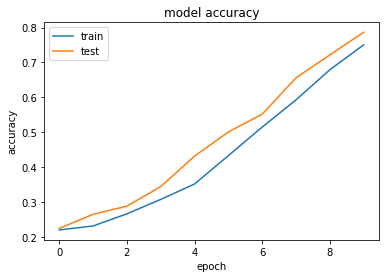

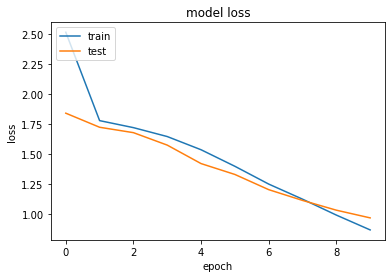

In [34]:
import matplotlib.pyplot as plt
%matplotlib inline 
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [35]:
#convolutional approach
convs = []
filter_sizes = [3,4,5]

sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)

for fsz in filter_sizes:
    l_conv = Conv1D(nb_filter=128,filter_length=fsz,activation='relu')(embedded_sequences)
    l_pool = MaxPooling1D(5)(l_conv)
    convs.append(l_pool)
    
l_merge = Concatenate(axis=1)(convs)
l_cov1= Conv1D(filters=128, kernel_size=5, activation='relu',padding='same')(l_merge)
l_pool1 = MaxPooling1D(5,padding='same')(l_cov1)
l_cov2 = Conv1D(filters=128, kernel_size=5, activation='relu',padding='same')(l_pool1)
l_pool2 = MaxPooling1D(30,padding='same')(l_cov2)
l_flat = Flatten()(l_pool2)
l_dense = Dense(128, activation='relu')(l_flat)
preds = Dense(6, activation='softmax')(l_dense)

model2 = Model(sequence_input, preds)
model2.compile(loss='categorical_crossentropy',
              optimizer='adadelta',
              metrics=['acc'])

print("Fitting a more complex convolutional neural network model")
model2.summary()
history2 = model2.fit(x_train, y_train, validation_data=(x_val, y_val),
          epochs=3, batch_size=32)
model2.save('model.h5')

C:\ProgramData\Anaconda3\envs\tensorflow_env\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=128, kernel_size=3)`
  if __name__ == '__main__':
C:\ProgramData\Anaconda3\envs\tensorflow_env\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=128, kernel_size=4)`
  if __name__ == '__main__':
C:\ProgramData\Anaconda3\envs\tensorflow_env\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=128, kernel_size=5)`
  if __name__ == '__main__':


Fitting a more complex convolutional neural network model
Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 100)          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 100, 100)     2095600     input_2[0][0]                    
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 98, 128)      38528       embedding_1[1][0]                
__________________________________________________________________________________________________
conv1d_3 (Conv1D)               (None, 97, 128)      51328       embedding_1[1][0]                
__________________________________

C:\ProgramData\Anaconda3\envs\tensorflow_env\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 9727 samples, validate on 6144 samples
Epoch 1/3
9727/9727 [==============================] - 21s 2ms/step - loss: 1.6215 - acc: 0.2818 - val_loss: 1.3151 - val_acc: 0.4312
Epoch 2/3
9727/9727 [==============================] - 21s 2ms/step - loss: 1.1606 - acc: 0.4986 - val_loss: 1.0696 - val_acc: 0.5535
Epoch 3/3
9727/9727 [==============================] - 20s 2ms/step - loss: 0.8833 - acc: 0.6292 - val_loss: 0.8375 - val_acc: 0.6943


dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


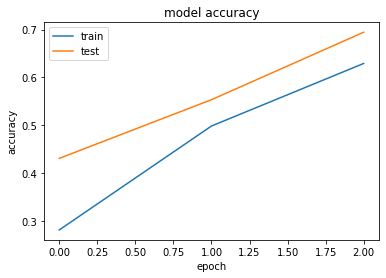

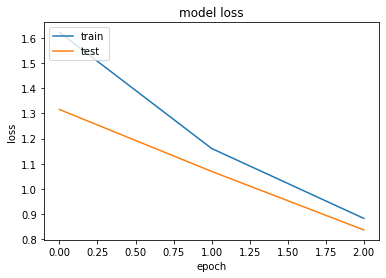

In [36]:
# list all data in history
print(history2.history.keys())
import matplotlib.pyplot as plt
%matplotlib inline 
# summarize history for accuracy
plt.plot(history2.history['acc'])
plt.plot(history2.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


Correct predictions: 3852.0
Total number of test examples: 4095
Accuracy of model1:  0.9406593406593406
Correct predictions: 3759.0
Total number of test examples: 4095
Accuracy of model2:  0.9179487179487179


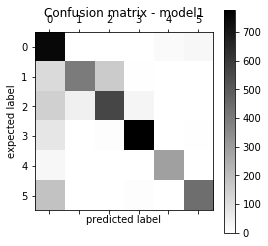

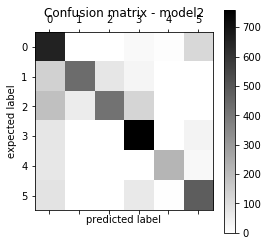

In [37]:
# Test model 1
test_preds = model.predict(x_test)
test_preds = np.round(test_preds)
correct_predictions = float(sum(test_preds == y_test)[0])
print("Correct predictions:", correct_predictions)
print("Total number of test examples:", len(y_test))
print("Accuracy of model1: ", correct_predictions/float(len(y_test)))

# Creating the Confusion Matrix
from sklearn.metrics import confusion_matrix
x_pred = model.predict(x_test)
x_pred = np.round(x_pred)
x_pred = x_pred.argmax(1)
y_test_s = y_test.argmax(1)
cm = confusion_matrix(y_test_s, x_pred)
plt.matshow(cm, cmap=plt.cm.binary, interpolation='nearest')
plt.title('Confusion matrix - model1')
plt.colorbar()
plt.ylabel('expected label')
plt.xlabel('predicted label')
# plt.show()

#Test model 2
test_preds2 = model2.predict(x_test)
test_preds2 = np.round(test_preds2)
correct_predictions = float(sum(test_preds2 == y_test)[0])
print("Correct predictions:", correct_predictions)
print("Total number of test examples:", len(y_test))
print("Accuracy of model2: ", correct_predictions/float(len(y_test)))

# Creating the Confusion Matrix
x_pred = model2.predict(x_test)
x_pred = np.round(x_pred)
x_pred = x_pred.argmax(1)
y_test_s = y_test.argmax(1)
cm = confusion_matrix(y_test_s, x_pred)
plt.matshow(cm, cmap=plt.cm.binary, interpolation='nearest',)
plt.title('Confusion matrix - model2')
plt.colorbar()
plt.ylabel('expected label')
plt.xlabel('predicted label')
plt.show()

In [38]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])


Test loss: 0.7364992049150851
Test accuracy: 0.8361416459083557


In [39]:
score = model2.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.6311708982174213
Test accuracy: 0.7606837749481201
